In [1]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize
from math import sin

In [2]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


In [3]:
##### NEW CLASS TO HAVE MULTIPLE SLOTS
class FirstPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = [adv_ranking[-1], adv_ranking[-2], adv_ranking[-3]] ## FOR NOW WE ARE USING 3 WINNING SLOTS --> THIS CODE IS HORRIBLE WE SHOULD PARAMETRIZE IT
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
      payment = []
      for i in len(winners):
          payment[i] = bids[winners[i]] ## WE HAD CHANGE ALSO THIS BECAUSE THERE WILL BE A PAYMENT FOR EACH WINNER
          payment[i].round(2)
      return payment

Let's configure the parameters to have the same values of the other parts of the project

In [39]:
import numpy as np

# Configuration parameters
ITERATIONS = 1000
AUCTIONS = 100
N_USERS = 1000
N_ADVERTISERS = 10    # number of companies that compete for slot auctions, including myself
NUMBER_OF_ARMS = 100    # needed for the UCB algorithm
PRICES = np.linspace(0, 1, NUMBER_OF_ARMS)    # actual arms of the ucb algorithm
BUGDET = 400 # I know it's mispelled but i found it like this in the other file so i kept it like this
NUMBER_OF_SLOTS = 3

lambda_fun_param = lambda s: 1/(s+(0.3))       # probability of the ad being seen given the position s ->  0.5 for first position, 0.33 for second, 0.25 for third, etc...
LAMBDAS = np.array([lambda_fun_param(i) for i in range(1, NUMBER_OF_SLOTS+1)])    # array of lambda values (for each slot)

Pattern definition

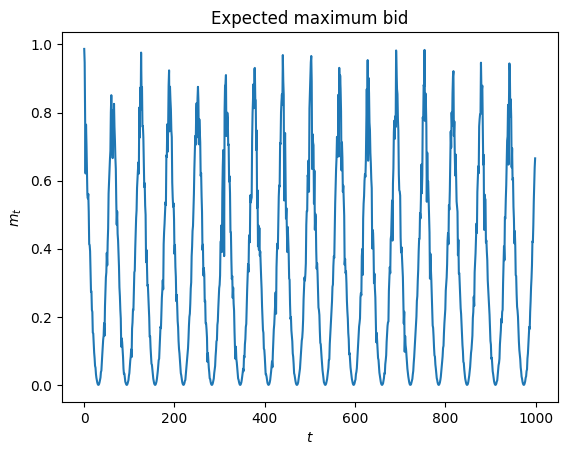

In [5]:
### Adversarial Bidders
#### interest !!
my_valuation = [0.8, 0.6, 0.4] #used in c ## NOW THERE ARE 3
rho = BUGDET/N_USERS

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 1-np.abs(np.sin(50*t/N_USERS))
other_bids = np.array([np.random.uniform(0, pattern(t), size = N_ADVERTISERS) for t in range(N_USERS)]).T
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

m_t = other_bids.max(axis=0)

plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()


clairvoyant

In [7]:
### THIS IS THE NEW BLOCK FOR THE CLAIRVOYANT INCLUDING MORE SLOTS
available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/len(available_bids) for b in available_bids]) ## ORIGINARIAMENTE C'ERA N_USERS INVECE DI LEN(AVAILABLE_BIDS) MA SECONDO ME NON AVEVA SENSO PERCHè PER CALCOLARE LA PROB DI VITTORIA DEVO FARE NUMBER OF BIDS THAT WOULD WIN / TOTAL NUMBER OF BIDS
## Linear Program
#linprog is a wayto optimize the function and the bid
k = np.array([])


## WE CONSIDERED C AS THE MEAN BECAUSE MY BID WILL BE ACTIVE FOR ALL THE 3 SLOTS, SO I NEED A UNIQUE VALUATION TO CHOOSE MY BID
for i in range(len(my_valuation)):
  k = np.append(k,-(my_valuation[i]-available_bids)*win_probabilities)

k_reshaped = k.reshape(3, 11) # we reshape it ot have it as a matrix, normal k is just an array that is not divided by slots
c = np.mean(k_reshaped, axis = 0) ## HERE WE COMPUTE THE MEAN
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(N_USERS)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(N_USERS)]

### Generalized Multiplicative Pacing for Non-Truthful Auctions

#### Here, we will assume a **full-feedback** setting. In auctions, full-feedback is equivalent of knowing the maximum bid $m_t$ that won the auction (of course, **after** the auction). Moreover, bids will be **discretized** into a finite set of actions.
Full feedback = You know th bid of each competitor

#### We will leverage a full-feedback, adversarial learner such as Hedge (see Lab 2).

In [8]:
class HedgeAgent:
    def __init__(self, narms, learning_rate): #ho tolto il numero di slot da questa classe per tenere solo narms
        self.narms = narms   #number of possible bids
        self.learning_rate = learning_rate #supposing it's the rate at which the algorithm progress
        self.weights = np.ones(narms) #weight == proportionnal to the probabilty
        self.x_t = np.ones(narms)/narms #probability of a bid to be played
        self.a_t = None # bid choice done during the round
        self.t = 0

    def pull_arm(self): #choose which arm to play
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.narms), p=self.x_t)
        return self.a_t

    def update(self, l_t): #update the weights
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [9]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set #available choices
        self.narms = len(bids_set) #nuber of bid choices
        self.hedge = HedgeAgent(self.narms, np.sqrt(np.log(self.narms)/T)) #qui ci va narms o nslots?? ma come learning rate non ci andrebbe eta??
        self.valuation = valuation #what you earn, ctr*profit_per_click
        self.budget = budget
        self.eta = eta #learning rate
        self.T = T  #number of rounds
        self.rho = self.budget/self.T #bid limit
        self.lmbd = 1 #pacing multiplier, when we spend more than rho it increses otherwise we decrease it
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(np.mean(self.valuation)-b)*int(b >= m_t) for b in self.bids_set]) ## WE TOOK THE MEAN OF MY VALUATION
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

## Trial

First iteration

In [29]:
############## NEW - MARCO'S TEST ######################

### THIS IS THE NEW BLOCK OF THE FIRST TRIAL CONSIDERING MULTIPLE SLOTS
eta = 1/np.sqrt(N_USERS)  # Learning rate from theory

### BEFORE CREATING THE AUCTION WE NEED TO DEFINE CTRS (CLICK TO RATES)
# to define it we need LAMBDA which represents the probability that a slot is seen by the users and Qa which represents the probability that a user click the ad after seeing it
# we'll have a vector LAMBDA with as many values as the number of slots and a vector Qa that will be 2D: i'll have a different value for a different advertiser and a different slot (N_ADVERTISERS ROWS and NUMBER_OF_SLOTS columns)
# the click to rates wll be defined as: ctrs = LAMBDAS*Qa
# we already have a LAMBDAS vector from the parameter definition above but we need to create a vectore Qa
q_a = np.random.rand(N_ADVERTISERS+1, NUMBER_OF_SLOTS)  # 11 rows (10 advertisers + me), 3 coloumns
ctrs = LAMBDAS*q_a
avg_ctrs = np.mean(ctrs, axis=1) # we compute the average among slots for each advertiser so we can pass this during the auction creation, otherwise it would be a mess to sort it and find the winners


# Initializing the agent and auction
agent = FFMultiplicativePacingAgent(bids_set=available_bids,
                                    valuation=my_valuation,
                                    budget=BUGDET,
                                    T=N_USERS,
                                    eta=eta)

auction = FirstPriceAuction(avg_ctrs)  # Auction setup

# Arrays to store results
utilities = np.array([])  # Utility gained in each auction
my_bids = np.array([])  # Bids placed by the agent
my_payments = np.array([])  # Payments made by the agent
total_wins = 0  # Counter for total wins

# Running the auction process
np.random.seed(1)  # Seed for reproducibility

for u in range(N_USERS):
    my_win = 0
    rank = 0
    # Agent places a bid
    my_bid = agent.bid()

    # Gather all bids for this auction
    bids = np.append(my_bid, other_bids[:, u].ravel())
    m_t_new = np.max(bids)

    # Determine winners and payments
    winners, payments_per_click = auction.get_winners(bids=bids)

    # Check if the agent won
    #WE ADDED THIS FOR CICLE TO CHECK IF I WON AT LEAST ONE SLOT
    for i in range(len(winners)):
      if winners[i]==0:
        my_win = 1
        rank = i # THIS IS TO CHEK LATER THE UTILITY CONSIDERING THE VALUATION OF THE SLOT I WON

    # Calculate the utility and payment for the agent
    f_t = (my_valuation[rank] - m_t_new) * my_win  # Utility when the agent wins #WE ARE CONSIDERING RANK FOR THE RIGHT VALUATION
    c_t = my_bid * my_win  # Payment if the agent wins

    # Update the agent's learning based on the auction outcome
    agent.update(f_t, c_t, m_t_new)

    # Store the results
    utilities = np.append(utilities, f_t)  # Append utility
    my_bids = np.append(my_bids, my_bid)  # Append bid
    my_payments = np.append(my_payments, c_t)  # Append payment
    total_wins += my_win  # Increment total wins

    cumulative_payments = np.cumsum(my_payments)

    # Nicely formatted output to track progress
    print(f"\nIteration {u}:")  # New line for each iteration
    print(f"  My bid            : {my_bid:.2f}")
    print(f"  All bids          : {bids}")
    print(f"  All values        : {bids*avg_ctrs}")
    print(f"  Winners           : {winners}")
    print(f"  My win            : {my_win}")
    print(f"  m_t[{u}]          : {m_t_new:.2f}")
    print(f"  c_t               : {c_t:.2f}")
    print(f"  Total wins so far : {total_wins}")
    print(f"  Current payment   : {my_payments[u]}")
    print(f"  Total paid so far : {cumulative_payments[u]}")

# Display total number of wins at the end
print(f"Total number of wins: {total_wins}")


Streaming output truncated to the last 5000 lines.
  All bids          : [0.2        0.08992964 0.00758317 0.10586621 0.04459641 0.02240705
 0.12901052 0.06853814 0.05607308 0.09992217 0.02124809]
  All values        : [0.04030847 0.024906   0.00121684 0.03597145 0.00633423 0.00450589
 0.03662866 0.02382479 0.02086165 0.02047531 0.00480406]
  Winners           : [0, 6, 3]
  My win            : 1
  m_t[649]          : 0.20
  c_t               : 0.20
  Total wins so far : 319
  Current payment   : 0.2
  Total paid so far : 140.59999999999994

Iteration 650:
  My bid            : 0.20
  All bids          : [0.2        0.08796566 0.09768721 0.10594929 0.02689948 0.10393571
 0.02034699 0.10735582 0.01847363 0.07972634 0.0878211 ]
  All values        : [0.04030847 0.02436207 0.01567546 0.03599968 0.00382065 0.02090068
 0.00577692 0.03731834 0.006873   0.01633693 0.01985578]
  Winners           : [0, 7, 3]
  My win            : 1
  m_t[650]          : 0.20
  c_t               : 0.20
  Total w

graphical representation

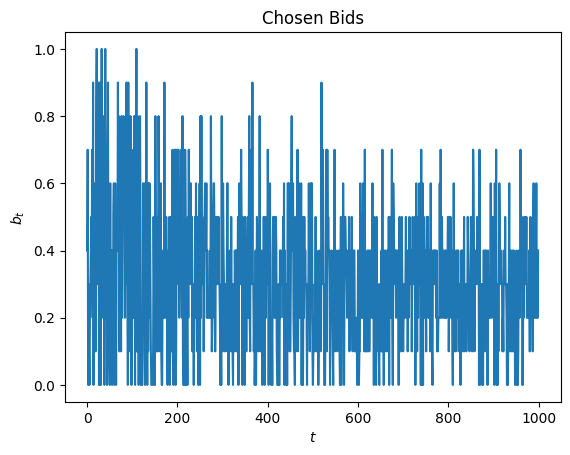

In [30]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

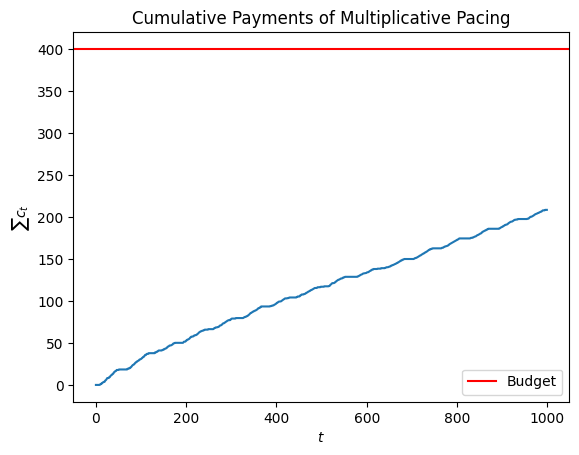

In [31]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(BUGDET, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

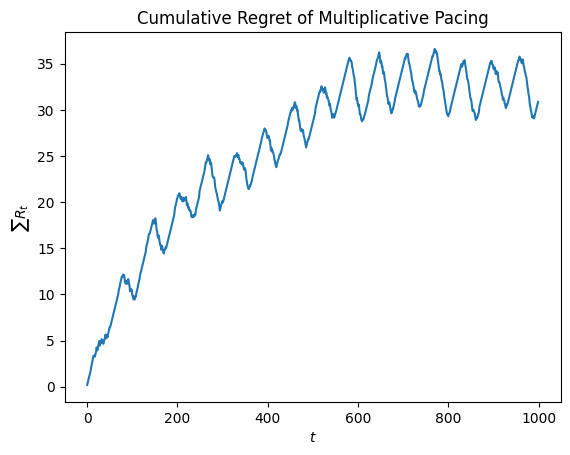

In [32]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()


Looks like we are obtaining sublinear regret

## now doing multiple rounds to have a better idea

In [43]:
### SAME OF BEFORE, THIS IS THE NEW BLOCK FOR MULTIPLE SLOTS
all_regrets = []
all_payments = []

eta = 1/np.sqrt(N_USERS)  # Learning rate from theory
q_a = np.random.rand(N_ADVERTISERS+1, NUMBER_OF_SLOTS)  # 11 rows (10 advertisers + me), 3 coloumns
ctrs = LAMBDAS*q_a
avg_ctrs = np.mean(ctrs, axis=1) # we compute the average among slots for each advertiser so we can pass this during the auction creation, otherwise it would be a mess to sort it and find the winners


for i in range(ITERATIONS):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids,
                                        valuation=my_valuation,
                                        budget=BUGDET,
                                        T=N_USERS,
                                        eta=eta)

    auction = FirstPriceAuction(avg_ctrs)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(N_USERS):
        my_win = 0
        rank = 0
        # Agent places a bid
        my_bid = agent.bid()

        # Gather all bids for this auction
        bids = np.append(my_bid, other_bids[:, u].ravel())
        m_t_new = np.max(bids)

        # Determine winners and payments
        winners, payments_per_click = auction.get_winners(bids=bids)

        # Check if the agent won
        #WE ADDED THIS FOR CICLE TO CHECK IF I WON AT LEAST ONE SLOT
        for i in range(len(winners)):
          if winners[i]==0:
            my_win = 1
            rank = i # THIS IS TO CHEK LATER THE UTILITY CONSIDERING THE VALUATION OF THE SLOT I WON

        # Calculate the utility and payment for the agent
        f_t = (my_valuation[rank] - m_t_new) * my_win  # Utility when the agent wins #WE ARE CONSIDERING RANK FOR THE RIGHT VALUATION
        c_t = my_bid * my_win  # Payment if the agent wins

        # Update the agent's learning based on the auction outcome
        agent.update(f_t, c_t, m_t_new)

        # Store the results
        utilities = np.append(utilities, f_t)  # Append utility
        my_bids = np.append(my_bids, my_bid)  # Append bid
        my_payments = np.append(my_payments, c_t)  # Append payment
        total_wins += my_win  # Increment total wins

        cumulative_payments = np.cumsum(my_payments)


    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(cumulative_payments)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

graphical representation

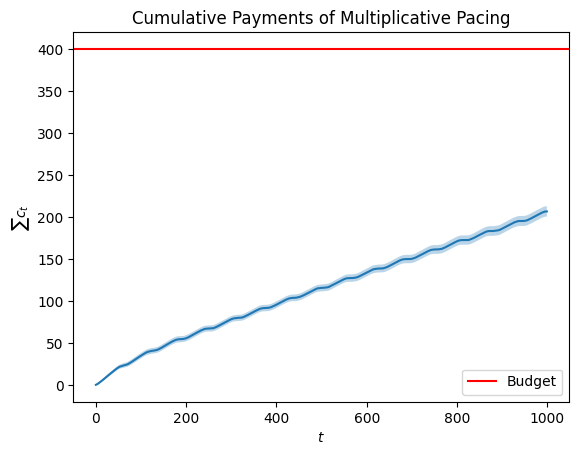

In [44]:
plt.plot(np.arange(N_USERS), avg_payments)
plt.fill_between(np.arange(N_USERS), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(BUGDET, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

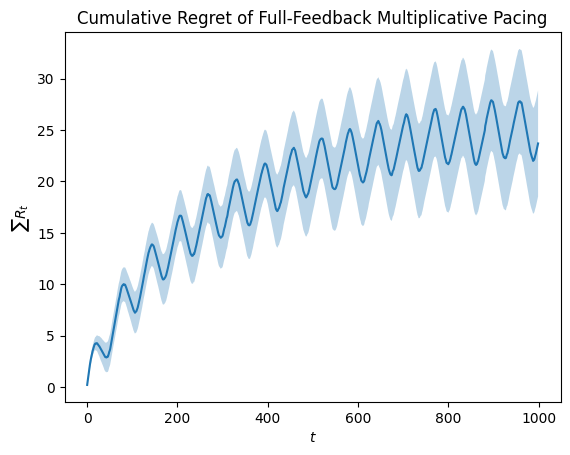

In [45]:
plt.plot(np.arange(N_USERS), avg_regret)
plt.fill_between(np.arange(N_USERS), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()